### Toy example on synthetic data ###

To illustrate the result of the Theorem 3.1, we can compare the Monge optimal transport map and the DDPM encoder map on 2d multivariate normal distributions. Given $\mu \sim \mathcal{N}(a,I_2)$ where $a\in \mathbb{R}^2$, we compute the Monge optimal transport map and the DDMP encoder map between $\mu$ and a reduced centered normal law $\mathcal{N}(0,I_2)$. 

First, lets draw some points according to $\mu \sim \mathcal{N}(a,I_2)$

In [87]:
import jax
import jax.random as jrd
import jax.numpy as jnp

key = jrd.PRNGKey(42)

mean = jnp.array([-10, -5.0]) 
covariance = jnp.array([[1.0, 0.], [0., 1.0]])
n_points = 10000

datapoints = jrd.multivariate_normal(key, mean, covariance, shape=(n_points,))

We can plot these points: 

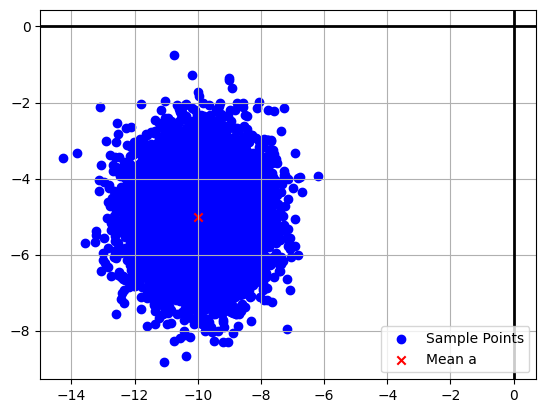

In [93]:
import matplotlib.pyplot as plt

plt.scatter(datapoints[:, 0], datapoints[:, 1], color='blue', label='Sample Points')
plt.axhline(0, color='black', linewidth=2)
plt.axvline(0, color='black', linewidth=2)
plt.scatter(-10, -5, color='red', marker='x', label='Mean a')
plt.legend()
plt.grid(True)
plt.show()

For the Monge optimal transport map, we use the Sinkhorn algorithm. 

In [ ]:
#### Add the code from ott-jax ##### 

Concerning the DDPM encoder map, we first transform our clean data (sample from $\mu \sim \mathcal{N}(a,I_2)$) into the gaussian distribution $\mathcal{N}(0,I_2)$ using the forward process: 
$$
q(x_{t}|x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t}x_{t-1}, \beta_t I)
$$
This step is done with the method $\texttt{diffuse}$ from the class $\texttt{DiffusionModel}$ (see the file DDPM.model.py)

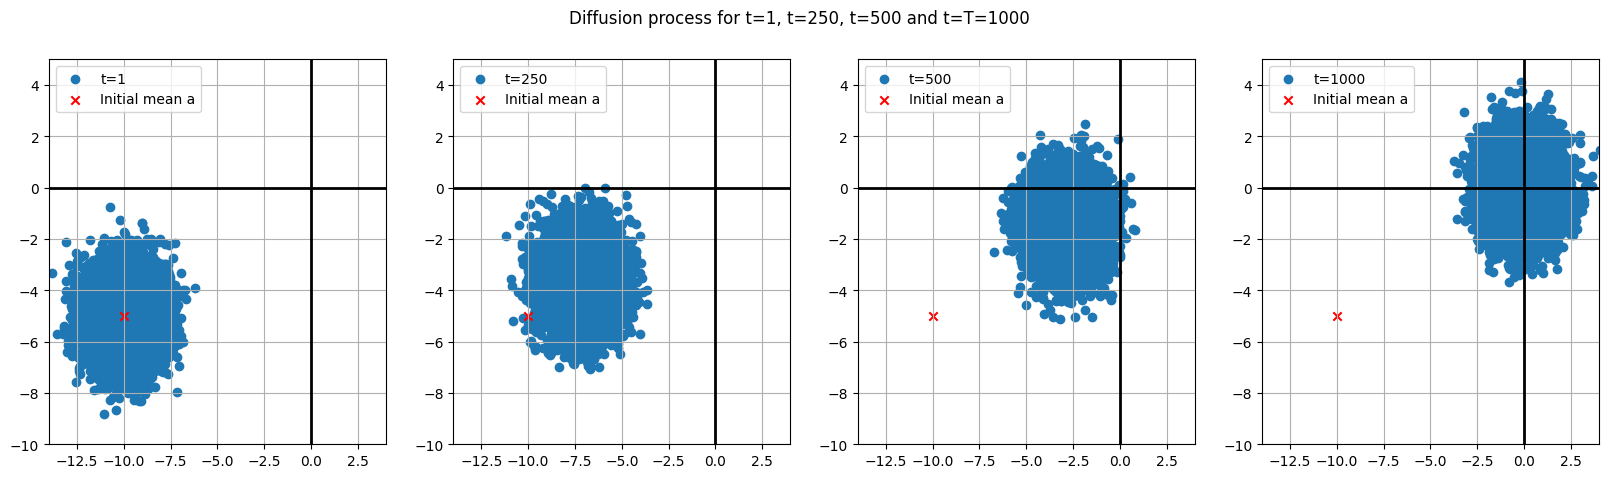

In [90]:
import torch
import numpy as np
from DDPM.model import DiffusionModel, NoiseModel

n_steps = 1000
beta_1 = 0.0001
beta_t = 0.02
device = "cuda" if torch.cuda.is_available() else "cpu"
 
model = NoiseModel(n_steps)
diffuser = DiffusionModel(model, n_steps, beta_1, beta_t, device)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
fig.suptitle("Diffusion process for t=1, t=250, t=500 and t=T=1000")
data_tensor = torch.Tensor(np.array(datapoints))
steps = [1, 250, 500, 1000]
for step, ax in zip(steps, axs):
    t = step * torch.ones([1,], dtype=torch.int32, device=device)
    eps, diffused = diffuser.diffuse(data_tensor, t)
    ax.scatter(diffused[:, 0], diffused[:, 1], label='t='+str(step))
    ax.set_xlim(-14, 4)
    ax.set_ylim(-10,5)
    ax.axhline(0, color='black', linewidth=2)
    ax.axvline(0, color='black', linewidth=2)
    ax.scatter(-10, -5, color='red', marker='x', label='Initial mean a')
    ax.legend()
    ax.grid(True)

Then, we train a noise predictor network $\epsilon_{\theta}$. All the training process is wrapped into the trainer $\texttt{DiffusionTrainer}$. (see the file DDPM.trainer.py)

100%|██████████| 100/100 [00:09<00:00, 10.23it/s]


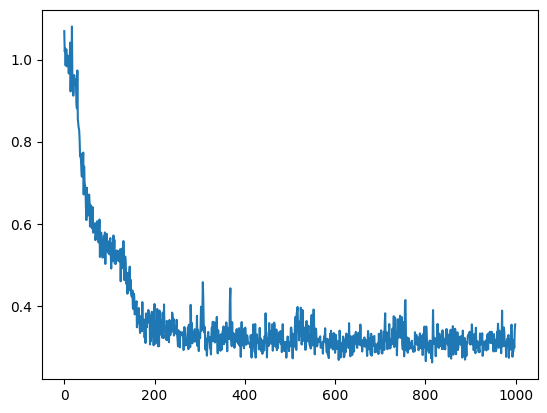

In [91]:
from DDPM.trainer import DiffusionTrainer

# Hyper parameters
batch_size = 1024
n_epochs = 100
lr = 0.003

trainer = DiffusionTrainer(data_tensor, batch_size, beta_1, beta_t, n_steps, lr, device)
all_losses = trainer.train(n_epochs)
plt.figure()
plt.plot(all_losses)
plt.show()

Given a noise $z \sim \mathcal{N}(0,I_2)$ and using the trained noise model, we run the backward process and thus obtain a sample distributed according to the initial distribution $\mathcal{N}(a,I_2)$

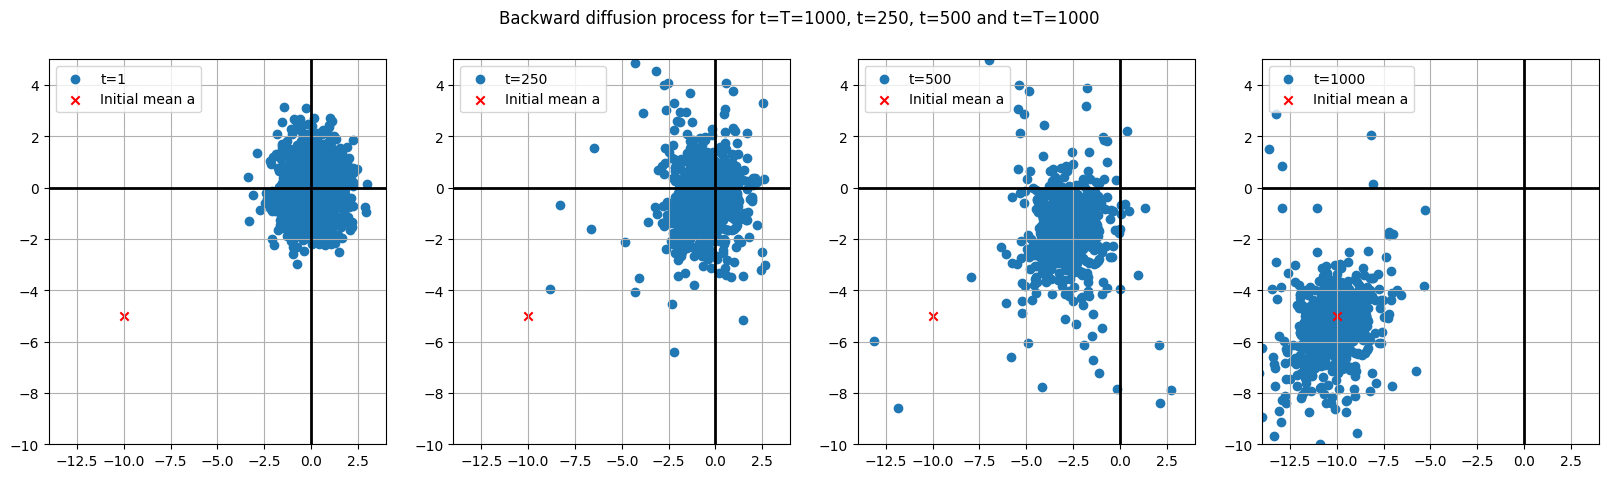

In [101]:
eval_data = torch.randn(1024,2)

trainer.diffuser.model.eval()
with torch.no_grad():
    output, all_outputs = trainer.diffuser.denoise(torch.Tensor(eval_data).to(device), n_steps-1)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
fig.suptitle("Backward diffusion process for t=T=1000, t=250, t=500 and t=T=1000")
data_tensor = torch.Tensor(np.array(datapoints))
steps = [1, 250, 500, 1000]
for step, ax in zip(steps, axs):
    ax.scatter(all_outputs[step-1][:, 0], all_outputs[step-1][:, 1], label='t='+str(step))
    ax.set_xlim(-14, 4)
    ax.set_ylim(-10,5)
    ax.axhline(0, color='black', linewidth=2)
    ax.axvline(0, color='black', linewidth=2)
    ax.scatter(-10, -5, color='red', marker='x', label='Initial mean a')
    ax.legend()
    ax.grid(True)